In [3]:
import os
import sys 
sys.path.append('../Netket/')
import analysis
import getpass
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd



In [4]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'

h5_files_opt = [os.path.join(f"{data_root}/data/data_optimal_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_optimal_basis_rbm') if f.endswith('.h5')]
df_opt = analysis.load_outputs_to_dataframe(h5_files_opt)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

h5_files_raw = [os.path.join(f"{data_root}/data/data_rand", f) for f in os.listdir(f'{data_root}/data/data_rand') if f.endswith('.h5')]
df_raw = analysis.load_outputs_to_dataframe(h5_files_raw)
df_raw = analysis.attach_hypotheses_fields(df_raw, hypotheses)
df_raw["idx"] = df_raw["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_raw))


230
230


In [5]:
df_opt["gap"] = df_opt["exact_energies"].apply(lambda energies: (energies[1] - energies[0]) if energies is not None and len(energies) >= 2 else np.nan)
df_raw["gap"] = df_raw["exact_energies"].apply(lambda energies: (energies[1] - energies[0]) if energies is not None and len(energies) >= 2 else np.nan)   

In [6]:
def filter_dataframe_by_range(df, field, lower_bound, upper_bound):
    """
    Filters the DataFrame to include only rows where the specified field's values
    are within the given range (exclusive).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        field (str): The column name to filter by.
        lower_bound (float): The lower bound of the range (exclusive).
        upper_bound (float): The upper bound of the range (exclusive).

    Returns:
        pd.DataFrame: A filtered DataFrame.
    """
    return df[(df[field] > lower_bound) & (df[field] < upper_bound)]

In [7]:
df_opt.head()

,psi,psi_0,Delta_E,E_exact,E_var,infidelity,exact_energies,exact_eigenstates,file,alpha,...,seed,show_progress,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,idx,gap
0,"[(-0.0025427437+0.0008543719j), (-0.002837049+...",[(0.0025405071122418135+0.00024646387204357634...,0.000382,-81.814826,-81.783540,0.000958,"[-81.8148261717988, -74.02698833531186, -73.82...",[[(0.0025405071122418135+0.0002464638720435763...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1,...,1234,False,0.179447,0.000042,0.978425,10.079338,0.761920,0.003465,81,7.787838
1,"[(-0.004116603+0.00049574394j), (-0.003818629-...",[(-0.0013475206333506294-0.003522024752844495j...,0.002817,-69.150261,-68.955462,0.010293,"[-69.15026084534408, -63.750697862446344, -63....",[[(-0.0013475206333506294-0.003522024752844495...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1,...,1234,False,0.548042,0.000019,0.997826,10.877749,0.703497,0.003803,189,5.399563
2,"[(0.00014552803-0.00014144064j), (0.0003331896...",[(-0.00011496701742952454-0.000289518582901006...,0.010822,-72.186099,-71.404927,0.077553,"[-72.18609904542315, -70.06838655150797, -68.7...",[[(-0.00011496701742952454-0.00028951858290100...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1,...,1234,False,0.571434,0.000234,0.955055,8.359235,0.475908,0.003180,968,2.117712
3,"[(-0.00035730805+4.5446377e-05j), (-5.567883e-...",[(3.739490233793871e-05-0.0005841252608470983j...,0.001868,-83.374726,-83.218955,0.501937,"[-83.37472641264299, -83.37082863905636, -72.3...",[[(3.739490233793871e-05-0.0005841252608470983...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1,...,1234,False,1.630023,0.000041,0.990663,10.113691,0.000204,0.003188,182,0.003898
4,"[(-0.0002150551+0.00374628j), (-0.0016604956+0...",[(-1.541220923218652e-05-0.00335446563213823j)...,0.001916,-63.386763,-63.265333,0.006239,"[-63.38676336863697, -57.81030080512207, -57.7...",[[(-1.541220923218652e-05-0.00335446563213823j...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1,...,1234,False,0.409339,0.000042,0.980519,10.073536,0.705761,0.003542,504,5.576463


[]


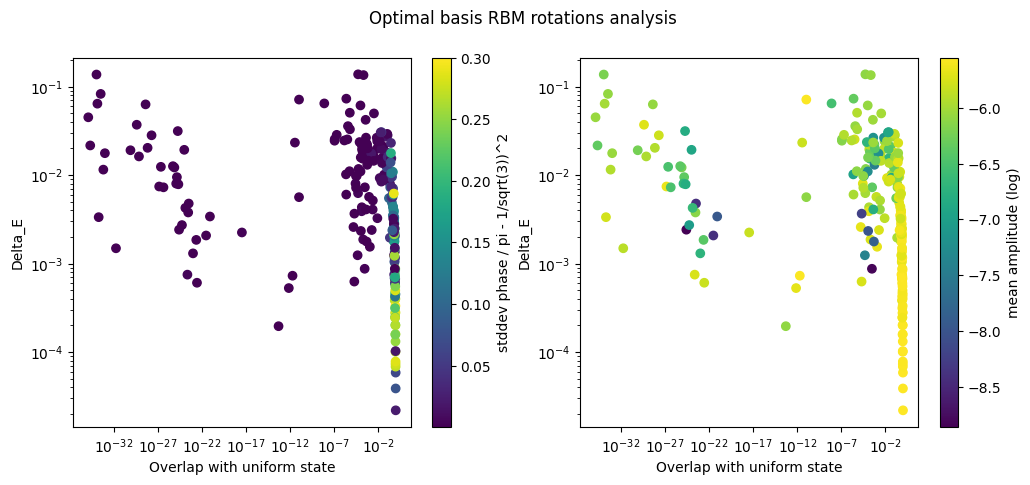

In [8]:
%matplotlib inline
# Scatter each hypothesis value vs the measured infidelity (uses df_eval if present)
df_rot_filter = df_opt
infidelity_ansatz_overlap = [abs(sum(psi_1))**2 / len(psi_1) for psi_1 in df_rot_filter.psi_0.values]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=(df_rot_filter.std_phase/np.pi - 1./np.sqrt(3))**2, cmap='viridis')
ax[0].set_xlabel("Overlap with uniform state")
ax[0].set_ylabel("Delta_E")
m = ax[0].collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax[0])
cbar0.set_label('stddev phase / pi - 1/sqrt(3))^2')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=np.log(df_rot_filter.mean_amplitude), cmap='viridis')
ax[1].set_xlabel("Overlap with uniform state")
ax[1].set_ylabel("Delta_E")
m1 = ax[1].collections[-1]  # get the scatter collection just created
cbar1 = fig.colorbar(m1, ax=ax[1])
cbar1.set_label('mean amplitude (log)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')


# ax[0].legend()
fig.suptitle("Optimal basis RBM rotations analysis")
handles, labels = ax[0].get_legend_handles_labels()
print(labels)


[]


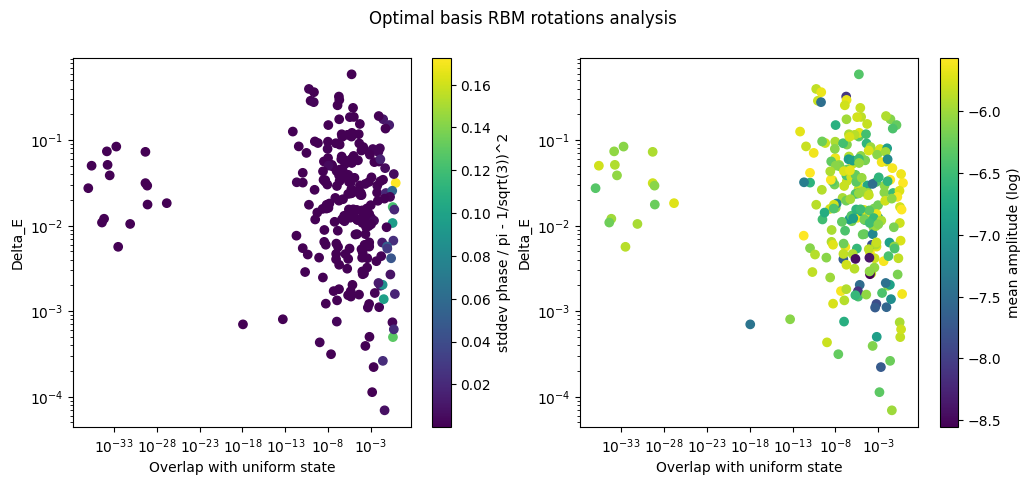

In [9]:
%matplotlib inline
# Scatter each hypothesis value vs the measured infidelity (uses df_eval if present)
df_rot_filter = df_raw
infidelity_ansatz_overlap = [abs(sum(psi_1))**2 / len(psi_1) for psi_1 in df_rot_filter.psi_0.values]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=(df_rot_filter.std_phase/np.pi - 1./np.sqrt(3))**2, cmap='viridis')
ax[0].set_xlabel("Overlap with uniform state")
ax[0].set_ylabel("Delta_E")
m = ax[0].collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax[0])
cbar0.set_label('stddev phase / pi - 1/sqrt(3))^2')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=np.log(df_rot_filter.mean_amplitude), cmap='viridis')
ax[1].set_xlabel("Overlap with uniform state")
ax[1].set_ylabel("Delta_E")
m1 = ax[1].collections[-1]  # get the scatter collection just created
cbar1 = fig.colorbar(m1, ax=ax[1])
cbar1.set_label('mean amplitude (log)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')


# ax[0].legend()
fig.suptitle("Optimal basis RBM rotations analysis")
handles, labels = ax[0].get_legend_handles_labels()
print(labels)


In [10]:
import pandas as pd

def align_df2_to_df1_idx(df1, df2, key='idx', keep_extra=True, drop_missing=False):
    """
    Return a reordered copy of df2 so its rows with 'key' appear in the same order
    as in df1.

    Parameters:
        df1, df2 : pandas.DataFrame
            Input dataframes (both must contain column `key`).
        key : str
            Column name used for alignment (default 'idx').
        keep_extra : bool
            If True, rows in df2 whose key is not present in df1 are appended at the end.
        drop_missing : bool
            If True, keys present in df1 but missing in df2 are omitted from the result.
            If False, those positions will appear as rows with NaNs (unless df2 had them).

    Returns:
        pandas.DataFrame : reordered copy of df2
    """
    if key not in df1.columns:
        raise KeyError(f"{key!r} not found in df1")
    if key not in df2.columns:
        raise KeyError(f"{key!r} not found in df2")

    order = list(df1[key].values)
    df2_idx = df2.set_index(key)

    if drop_missing:
        aligned = df2_idx.reindex(order).dropna(how='all').reset_index()
    else:
        aligned = df2_idx.reindex(order).reset_index()

    if keep_extra:
        extras = df2[~df2[key].isin(order)]
        if not extras.empty:
            aligned = pd.concat([aligned, extras], ignore_index=True, sort=False)

    return aligned

# Example usage:
# df2_ordered = align_df2_to_df1_idx(df_opt, df_raw)  # reorder df_raw to match df_opt idx order

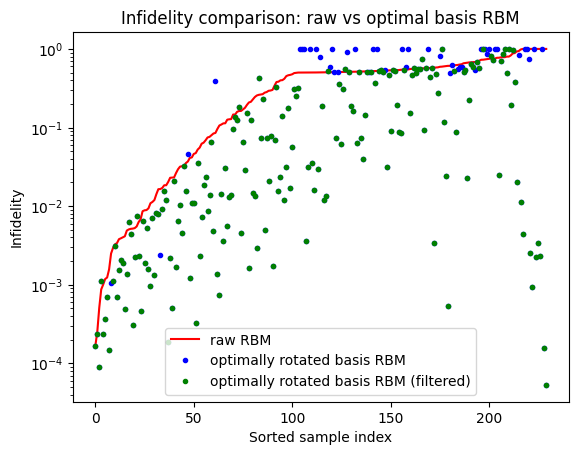

In [27]:
%matplotlib inline
fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='infidelity')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
filt_sortedopt = filter_dataframe_by_range(sortedopt, 'uniform_state_overlap', 1e-10,1.0)
filt_sortedopt = align_df2_to_df1_idx(sorteddraw, filt_sortedopt, 'idx')

ax.plot(sorteddraw.infidelity.values, c='red',label='raw RBM')
ax.plot(sortedopt.infidelity.values, c='blue', marker='.',ls='None', label='optimally rotated basis RBM')
ax.plot(filt_sortedopt.infidelity.values, c='green', marker='.',ls='None', label='optimally rotated basis RBM (filtered)')
ax.set_title("Infidelity comparison: raw vs optimal basis RBM")
ax.set_ylabel("Infidelity")
ax.set_xlabel("Sorted sample index")
ax.legend() 

In [12]:
def infidelity_ansatz_overlap(psi_0_list):
    """
    Calculates the overlap with the uniform state for a list of wavefunctions.

    Parameters:
        psi_0_list (iterable): An iterable of wavefunctions (each a numpy array or list of amplitudes).

    Returns:
        list: Overlap values for each wavefunction.
    """
    return [abs(np.sum(psi_0))**2 / len(psi_0) for psi_0 in psi_0_list]

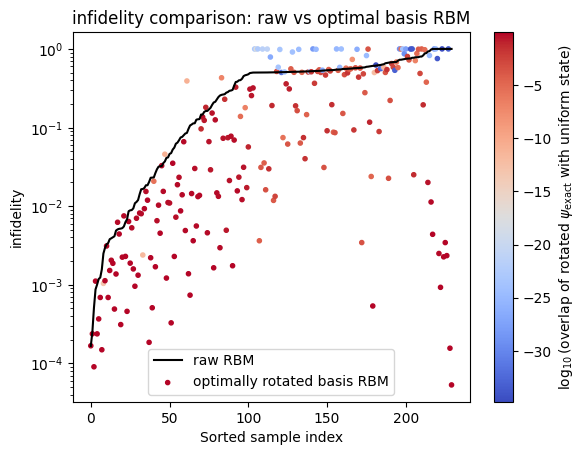

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='infidelity')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
ax.plot(sorteddraw.infidelity.values, c='black',label='raw RBM')
ax.scatter(np.arange(len(sortedopt.infidelity.values)), sortedopt.infidelity.values, 
          c=np.log10(infidelity_ansatz_overlap(sortedopt.psi_0)), 
          cmap='coolwarm', marker='.', label='optimally rotated basis RBM')

m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(overlap of rotated $\psi_{\mathrm{exact}}$ with uniform state)')

ax.set_title("infidelity comparison: raw vs optimal basis RBM")
ax.set_ylabel("infidelity")
ax.set_xlabel("Sorted sample index")
ax.legend() 


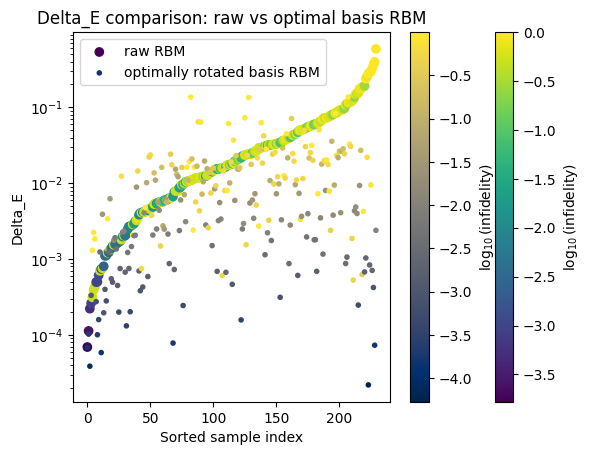

In [14]:
%matplotlib inline
fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='Delta_E')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
ax.scatter(np.arange(len(sorteddraw.Delta_E.values)), sorteddraw.Delta_E.values, 
        c=np.log10(sorteddraw.infidelity.values), cmap='viridis', label='raw RBM')
m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(infidelity)')




ax.scatter(np.arange(len(sortedopt.Delta_E.values)), sortedopt.Delta_E.values, 
          c=np.log10(sortedopt.infidelity.values), 
          cmap='cividis', marker='.', label='optimally rotated basis RBM')
m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(infidelity)')

ax.set_title("Delta_E comparison: raw vs optimal basis RBM")
ax.set_ylabel("Delta_E")
ax.set_xlabel("Sorted sample index")
ax.legend() 

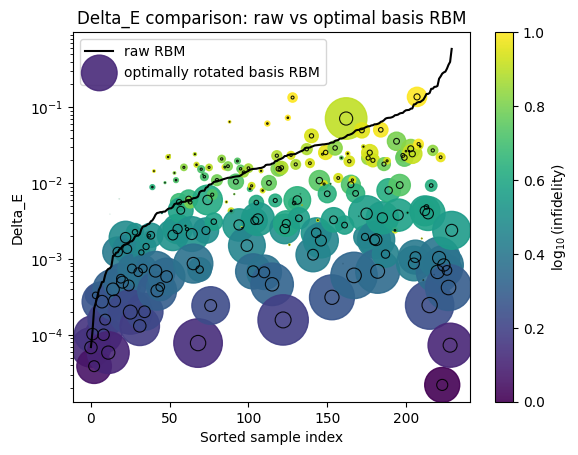

In [ ]:
%matplotlib inline
def energy_gap(df):
    gaps = []
    for energies in df['exact_energies']:
        if energies is not None and len(energies) >= 2:
            gap = energies[1] - energies[0]
        else:
            gap = np.nan  # or some other placeholder for missing data
        gaps.append(gap)
    return gaps

fig, ax = plt.subplots(1)
ax.set_yscale('log')
sorteddraw = df_raw.sort_values(by='Delta_E')
sortedopt = align_df2_to_df1_idx(sorteddraw, df_opt, 'idx')
filt_sortedopt = align_df2_to_df1_idx(sorteddraw, filt_sortedopt, 'idx')
# ax.scatter(np.arange(len(sorteddraw.Delta_E.values)), sorteddraw.Delta_E.values, 
        # c=np.log10(sortedopt.gap.values), cmap='inferno', label='raw RBM')
ax.plot(np.arange(len(sorteddraw.Delta_E.values)), sorteddraw.Delta_E.values, 
        c="black", label='raw RBM')
# m = ax.collections[-1]  # get the scatter collection just created
# cbar0 = fig.colorbar(m, ax=ax)
# cbar0.set_label(r'$\log_{10}$(gap)')

maxgapratio = np.max(np.abs(filt_sortedopt.gap.values/filt_sortedopt.E_exact.values))
gapratio = np.abs(filt_sortedopt.gap.values/filt_sortedopt.E_exact.values)

ax.scatter(np.arange(len(filt_sortedopt.Delta_E.values)), filt_sortedopt.Delta_E.values, 
          c=np.log10(filt_sortedopt.infidelity.values), 
          cmap='viridis', marker='o', label='optimally rotated basis RBM', s=100*(np.abs(filt_sortedopt.gap.values)),alpha=0.9)
ax.scatter(np.arange(len(filt_sortedopt.Delta_E.values)), filt_sortedopt.Delta_E.values,
           marker='o', edgecolors='black', facecolors='none',
           s=10 * (np.abs(filt_sortedopt.gap.values)), linewidths=0.8, alpha=0.9)
m = ax.collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax)
cbar0.set_label(r'$\log_{10}$(infidelity)')

ax.set_title("Delta_E comparison: raw vs optimal basis RBM")
ax.set_ylabel("Delta_E")
ax.set_xlabel("Sorted sample index")
ax.legend() 

In [16]:
sortedopt.head()

,idx,psi,psi_0,Delta_E,E_exact,E_var,infidelity,exact_energies,exact_eigenstates,file,...,out,seed,show_progress,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,gap
0,838,"[(0.0024359243+0.0031992274j), (0.002557759+0....",[(-0.0034252757004983015-0.0019603367094534036...,0.000068,-68.817924,-68.813218,0.000167,"[-68.81792421480071, -60.80580428310742, -60.3...",[[(-0.0034252757004983015-0.001960336709453403...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,0.176329,0.000019,0.995792,10.892416,9.540043e-01,0.003822,8.012120
1,997,"[(0.00266061-0.0029088717j), (0.0028396137-0.0...",[(-0.0034440515105044664+0.0020550889497098247...,0.000103,-57.928155,-57.922217,0.000238,"[-57.9281552705367, -51.072793589146286, -50.0...",[[(-0.0034440515105044664+0.002055088949709824...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,1.405727,0.000017,0.997282,10.964002,9.472633e-01,0.003847,6.855362
2,888,"[(-0.00026114928+0.002674608j), (-0.0005553632...",[(-0.0024487636718072557+0.0011072490058719635...,0.000039,-63.104504,-63.102058,0.000090,"[-63.10450444171446, -56.924565590625996, -55....",[[(-0.0024487636718072557+0.001107249005871963...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,2.692010,0.000016,0.999324,11.058784,9.750624e-01,0.003891,6.179939
3,1,"[(0.018178806-0.00016717562j), (0.011473363-0....","[(-0.013435672843449138+0.01407718758399147j),...",0.000333,-59.347367,-59.327627,0.001113,"[-59.34736709702083, -57.162323104129776, -56....",[[(-0.013435672843449138+0.01407718758399147j)...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,0.092658,0.000022,0.992489,10.741295,9.131624e-01,0.003749,2.185044
4,876,"[(-0.0001155107+0.00028950378j), (-0.000325498...",[(1.5004958629694588e-15+1.7223654030218835e-1...,0.001303,-65.179344,-65.094431,0.998649,"[-65.17934389860874, -65.18346362181418, -55.5...",[[(1.5004958629694588e-15+1.7223654030218835e-...,../data/data_optimal_basis_rbm/rbm_optimizatio...,...,../data/data_optimal_basis_rbm/rbm_optimizatio...,1234,False,1.836834,0.004501,0.695800,5.403504,1.028352e-23,0.001200,-0.004120


In [17]:
len(sortedopt), len(filt_sortedopt)

(230, 230)

/tmp/ipykernel_1213066/2577684784.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


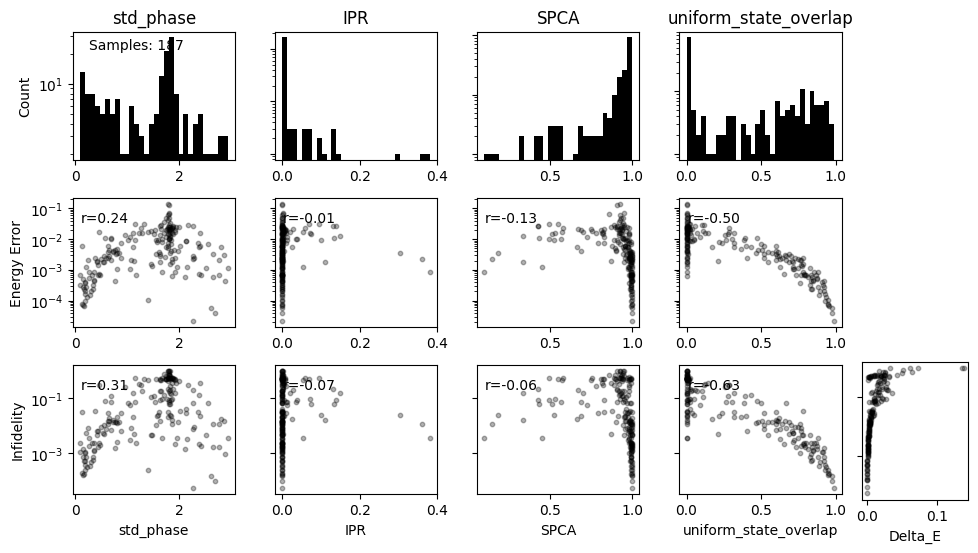

In [28]:
def plotCorrelations(df_eval, hypotheses, plt_fig=None, text_offset=None, color="black", alphamod=1., ylog=False, xlog=False, pearson=False):
    scatter_size = 10
    N = len(hypotheses)
    if plt_fig is None:
        fig = plt.figure(figsize=(0.6*4*N + 1, 0.6*10))  # Extra width for colorbar
        gs = gridspec.GridSpec(3, N+1, width_ratios=[1]*N + [0.08], wspace=0.3, hspace=0.3)
        axes = np.empty((3, N), dtype=object)
        for row in range(3):
            for col in range(N):
                axes[row, col] = fig.add_subplot(gs[row, col])
        bottom_right_ax = fig.add_subplot(gs[-1, -1])
        
    else:
        fig = plt_fig
        all_axes = fig.get_axes()
        axes = np.array(all_axes[:3*N]).reshape(3, N)
        bottom_right_ax = all_axes[-1]
        # The last axis (all_axes[3*N]) is the colorbar or extra axis

    for idx, name in enumerate(hypotheses.keys()):
        if name == "mean_phase":
            data = df_eval[name].abs()
            title = f"|{name}|"
        else:
            data = df_eval[name]
            title = name
        axes[0, idx].hist(data, bins=30, color=color,alpha = alphamod)
        axes[0, idx].set_title(title)
        if idx == 0:
            axes[0, 0].set_ylabel("Count")
        else:
            axes[0, idx].tick_params(axis='y', labelleft=False)

        scatter = axes[1, idx].scatter(data, df_eval["Delta_E"], alpha=0.3*alphamod, s=scatter_size, color=color)
        if idx == 0:
            axes[1, 0].set_ylabel("Energy Error")
        else:
            axes[1, idx].tick_params(axis='y', labelleft=False)
        axes[2, idx].scatter(data, df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
        axes[2, idx].set_xlabel(title)
        if idx == 0:
            axes[2, 0].set_ylabel("Infidelity")
        else:
            axes[2, idx].tick_params(axis='y', labelleft=False)

        if ylog:
            # apply log scale to y-axis for all three rows for this column
            axes[0, idx].set_yscale('log')
            axes[1, idx].set_yscale('log')
            axes[2, idx].set_yscale('log')
        if xlog:
            axes[0, idx].set_xscale('log')
            axes[1, idx].set_xscale('log')
            axes[2, idx].set_xscale('log')
        if pearson:
            from scipy.stats import pearsonr
            r_deltaE, _ = pearsonr(data, df_eval["Delta_E"])
            r_infidelity, _ = pearsonr(data, df_eval["infidelity"])
            axes[1, idx].text(0.05, 0.9, f"r={r_deltaE:.2f}", transform=axes[1, idx].transAxes, fontsize=10, color=color, ha="left", va="top")
            axes[2, idx].text(0.05, 0.9, f"r={r_infidelity:.2f}", transform=axes[2, idx].transAxes, fontsize=10, color=color, ha="left", va="top")
    plt.tight_layout()

    bottom_right_ax.set_position([0.87, 0.1, 0.1, 0.23])
    bottom_right_ax.tick_params(axis='y', labelleft=False)
    bottom_right_ax.scatter(df_eval["Delta_E"], df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
    bottom_right_ax.set_xlabel("Delta_E")
    if ylog:
        bottom_right_ax.set_yscale('log')
    if text_offset is None:
        text_offset = [0,0]
        if plt_fig is not None:
            text_offset = [0.0,-0.15]
    text_pos = np.array([0.1, 0.95]) + np.array(text_offset)
    axes[0, 0].text(*text_pos, f"Samples: {len(df_eval)}", transform=axes[0, 0].transAxes, fontsize=10, color=color, ha="left", va="top")
    return fig

hyptheses_trim = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
}
infidelityrange = (0,1)
df_eval = filter_dataframe_by_range(filt_sortedopt, 'infidelity', *infidelityrange)
plt_fig = plotCorrelations(df_eval,hyptheses_trim,ylog=True,xlog=False,pearson=True)